In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import re


In [2]:
df = pd.read_csv('results.csv')

In [3]:
required_columns = ['rule', 'resource', 'files', 'asctime', 'dataset']

In [4]:
reduced_df = df[required_columns]

In [5]:
reduced_df.to_csv('reduced_results.csv', index=False)

In [9]:
reduced_df.sort_values(by=['asctime'], inplace=True)

/tmp/ipykernel_117007/2691685458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df.sort_values(by=['asctime'], inplace=True)


In [3]:
reduced_df = pd.read_csv('reduced_results.csv')

In [4]:
reduced_df.head()

,rule,resource,files,asctime,dataset
0,type=DATADISK&datapolicynucleus=True,IN2P3-CC_TAPE,2987,"2021-12-09 20:26:09,854",data16_13TeV:data16_13TeV.00307656.physics_Bph...
1,type=DATADISK&datapolicynucleus=True,IN2P3-CC_TAPE,38,"2021-12-09 20:26:10,250",data16_13TeV:data16_13TeV.00310015.physics_Bph...
2,type=DATADISK&datapolicynucleus=True,IN2P3-CC_TAPE,1499,"2021-12-09 20:26:10,613",data16_13TeV:data16_13TeV.00310249.physics_Bph...
3,type=DATADISK&datapolicynucleus=True,IN2P3-CC_TAPE,703,"2021-12-09 20:26:10,939",data16_13TeV:data16_13TeV.00310969.physics_Bph...
4,type=DATADISK&datapolicynucleus=True,FZK-LCG2_TAPE,2524,"2021-12-10 02:26:10,490",data16_13TeV:data16_13TeV.00303943.physics_Bph...


In [5]:
reduced_df['asctime'] = pd.to_datetime(reduced_df['asctime'])

/tmp/ipykernel_127507/3966752973.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reduced_df['asctime'] = pd.to_datetime(reduced_df['asctime'])


In [6]:
# Function to extract the scope from dataset names
def extract_scope(dataset_name):
    if ":" in dataset_name:
        return dataset_name.split(":")[0]  # Take part before the colon
    else:
        return dataset_name.split(".")[0]  # Otherwise, take part before the first dot

In [7]:
# Extract scopes and get unique values
unique_scopes = reduced_df['dataset'].apply(extract_scope).unique().tolist()

# Print the result
print(unique_scopes)

['data16_13TeV', 'data17_5TeV', 'mc16_13TeV', 'data17_13TeV', 'data15_13TeV', 'data18_13TeV', 'mc16_5TeV', 'valid1', 'mc15_13TeV', 'data18_hi', 'mc20_13TeV', 'mc15_14TeV', 'mc16_pPb8TeV', 'data22_13p6TeV', 'mc15_5TeV', 'data15_hi', 'data16_hip5TeV', 'data18_900GeV', 'data22_cos', 'data23_13p6TeV', 'data23_900GeV', 'data23_cos', 'data22_hi', 'data17_cos', 'data18_cos', 'data16_cos', 'mc23_13p6TeV', 'data23_hi', 'mc21_13p6TeV', 'mc21_14TeV', 'data24_13p6TeV', 'data16_hip8TeV', 'data24_5p36TeV']


In [22]:
reduced_df.dtypes

rule                object
resource            object
files                int64
asctime     datetime64[ns]
dataset             object
dtype: object

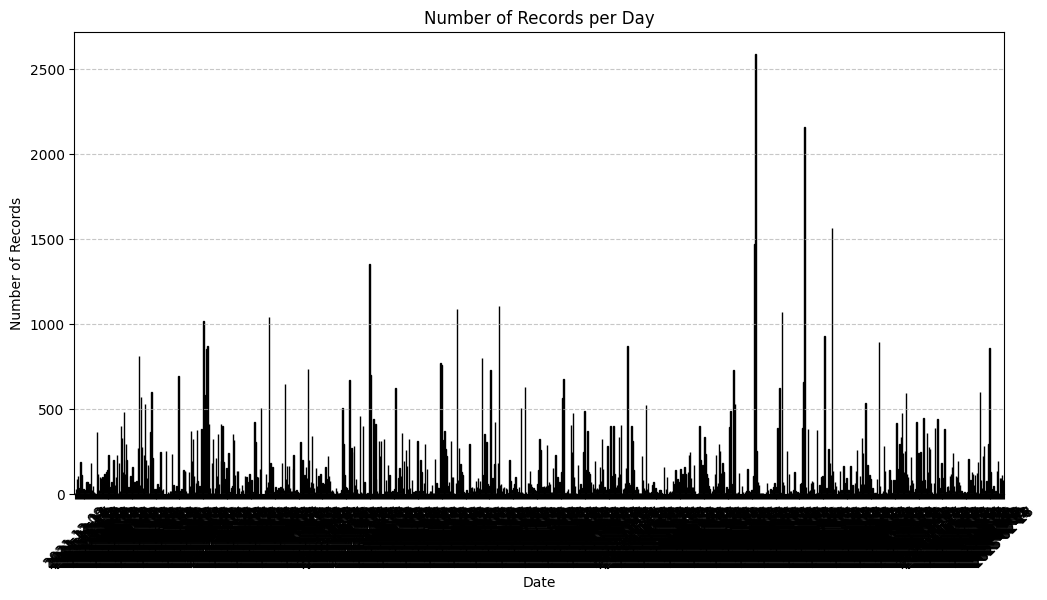

In [26]:
# Group by date (without time) and count records
daily_counts = reduced_df.groupby(reduced_df['asctime'].dt.date).size()

# Plot the results
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Number of Records per Day')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
feb_2024.shape

(2569, 5)

In [8]:
import re

def parse_scope(scope):
    # Initialize parsed dictionary
    parsed = {
        "dataset_origin": None,
        "year": None,
        "energy": None,
        "b_unit": None,
        "dataset_category": None
    }

    # Regex to capture dataset origin and optional year + energy
    pattern = r"^(?P<dataset_origin>mc|data|valid)(?P<year>\d{2})?(?:_(?P<energy>[0-9p]+)(?P<b_unit>TeV|GeV))?"

    match = re.match(pattern, scope)
    
    if match:
        parsed.update(match.groupdict())

        # Convert energy like "13p6" -> "13.6"
        if parsed["energy"]:
            parsed["energy"] = parsed["energy"].replace("p", ".")

        # Identify dataset category based on specific keywords
        if "hi" in scope:
            parsed["dataset_category"] = "heavy_ion"
        elif "cos" in scope:
            parsed["dataset_category"] = "cosmic"
        elif "pPb" in scope or "hip" in scope:
            parsed["dataset_category"] = "proton_lead"
        else:
            parsed["dataset_category"] = "standard"

        # If "valid" scope, ignore any numbers after it
        if parsed["dataset_origin"] == "valid":
            parsed["year"] = None  # Ignore the year for validation datasets

    else:
        print(f"Failed to match dataset origin with pattern: {scope}")
        parsed["dataset_category"] = "unknown"

    return parsed


In [9]:
# Function to parse the full dataset name
def parse_full_dataset_name(dataset_name):
    # Split the dataset name by colon
    parts = dataset_name.split(":")
    scope = parts[0]
    # print(parts)
    # print(len(parts))
    if len(parts) != 2:
        scope = dataset_name.split(".")[0]
    
    # Parse the first part using parse_dataset_name
    dataset_info = parse_scope(scope)
    if dataset_info is None:
        print(f"Failed to parse dataset origin: {scope}")
        return None  # Skip dataset names where the first part doesn't match
    
    # Split the second part by dots
    if len(parts) > 1:
        second_part = parts[1].split(".")
    else:
        second_part = dataset_name.split(".")
    
    # Extract the entities from the second part
    datasetid = second_part[1]  # First column is datasetid
    physics_process = second_part[2]
    production_step = second_part[3]
    data_format = second_part[4] 
    ami_tags = None
    taskid = None
    if len(second_part) > 5: 
        ami_tags = re.sub(r'_tid.*', '', second_part[5])
        taskid_with_tid = second_part[-1]  
        match = re.search(r'_tid(\d+)', taskid_with_tid)  # Regex to capture digits after '_tid'
        if match:
            taskid = match.group(1)  # Return the captured group (the number after '_tid')
        else:
            taskid = None  # Return '' if '_tid' is not found
    #taskid = taskid_with_tid.replace('_tid', '') if taskid_with_tid else ''
    
    # Return the parsed data as a dictionary
    parsed_data = {
        "dataset_origin": dataset_info['dataset_origin'],
        "year": dataset_info['year'],
        "energy": dataset_info['energy'],
        "b_unit": dataset_info['b_unit'],
        "datasetid": datasetid,
        "physics_process": physics_process,
        "production_step": production_step,
        "data_format": data_format,
        "ami_tags": ami_tags,
        "root_taskID": taskid
    }
    
    return parsed_data

In [10]:
# Apply the parse_full_dataset_name function to the dataset_name column
parsed_columns = reduced_df['dataset'].apply(parse_full_dataset_name).apply(pd.Series)

# Check if parsing worked
print("Parsed Results:")
print(parsed_columns)

Parsed Results:
       dataset_origin year energy b_unit datasetid       physics_process  \
0                data   16     13    TeV  00307656  physics_BphysDelayed   
1                data   16     13    TeV  00310015  physics_BphysDelayed   
2                data   16     13    TeV  00310249  physics_BphysDelayed   
3                data   16     13    TeV  00310969  physics_BphysDelayed   
4                data   16     13    TeV  00303943  physics_BphysDelayed   
...               ...  ...    ...    ...       ...                   ...   
119711           data   18     13    TeV  00363096          physics_Main   
119712           data   18     13    TeV  00351160       physics_BphysLS   
119713           data   18     13    TeV  00363129          physics_Main   
119714           data   15     13    TeV  00276952          physics_Main   
119715           data   15     13    TeV  00280231          physics_Main   

       production_step data_format     ami_tags root_taskID  
0        

In [11]:
reduced_df = pd.concat([reduced_df, parsed_columns], axis=1)

In [12]:
reduced_df.to_csv('reduced_results_enriched.csv', index=False)

In [3]:
prodsys_logs = pd.read_csv('reduced_results_enriched.csv')

In [4]:
tasks_df = pd.read_csv('tasks_2025.csv')

In [40]:
tasks_df.head(10)

,TASKID,INPUTDATASET,PR_ID,SUBMIT_TIME,START_TIME
0,43169310,mc20_13TeV.700602.Sh_2212_llvv_os.deriv.DAOD_P...,61345,2025-02-04 14:19:01.000000,2025-02-04 14:20:52.000000
1,43169396,mc20_13TeV.364706.Pythia8EvtGen_A14NNPDF23LO_j...,61345,2025-02-04 14:19:14.000000,2025-02-04 14:54:00.000000
2,43169449,mc20_13TeV.407342.PhPy8EG_A14_ttbarHT1k5_hdamp...,61345,2025-02-04 14:19:22.000000,2025-02-04 15:24:27.000000
3,43169495,mc20_13TeV.700338.Sh_2211_Wenu_maxHTpTV2_BFilt...,61345,2025-02-04 14:19:29.000000,2025-02-04 14:52:21.000000
4,43169507,mc20_13TeV.700362.Sh_2211_Wenu2jets_Min_N_TCha...,61345,2025-02-04 14:19:31.000000,2025-02-04 14:22:51.000000
5,43169588,mc23_13p6TeV.700779.Sh_2214_Wenu_maxHTpTV2_CVe...,61345,2025-02-04 14:19:46.000000,2025-02-05 01:12:33.000000
6,43169658,mc23_13p6TeV.801166.Py8EG_A14NNPDF23LO_jj_JZ1....,61345,2025-02-04 14:19:59.000000,2025-02-04 14:23:36.000000
7,43169716,mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258...,61345,2025-02-04 14:20:08.000000,2025-02-04 14:54:51.000000
8,43169768,mc23_13p6TeV.701015.Sh_2214_llvvjj_ss.deriv.DA...,61345,2025-02-04 14:20:18.000000,2025-02-04 14:54:09.000000
9,43168790,mc20_13TeV.546041.MGPy8EG_A14N23LO_TT_tN1_1200...,61345,2025-02-04 14:17:35.144607,2025-02-04 14:17:59.000000


In [13]:
prodsys_logs[prodsys_logs['dataset'] == 'mc16_13TeV:mc16_13TeV.364703.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ3WithSW.merge.EVNT.e7142_e5984_tid23096544_00']

,rule,resource,files,asctime,dataset,dataset_origin,year,energy,b_unit,datasetid,physics_process,production_step,data_format,ami_tags,root_taskID
23,type=DATADISK&datapolicynucleus=True,IN2P3-CC_TAPE,1067,2021-12-10 13:26:12,mc16_13TeV:mc16_13TeV.364703.Pythia8EvtGen_A14...,mc,16,13,TeV,364703,Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ3WithSW,merge,EVNT,e7142_e5984,23096544
12743,type=DATADISK&datapolicynucleus=True,IN2P3-CC_TAPE,1067,2022-03-31 18:38:56,mc16_13TeV:mc16_13TeV.364703.Pythia8EvtGen_A14...,mc,16,13,TeV,364703,Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ3WithSW,merge,EVNT,e7142_e5984,23096544


In [6]:
prodsys_logs_2025 = prodsys_logs[prodsys_logs['asctime'] >= '2025-01-01']

In [7]:
# Step 1: Extract the dataset name from 'feb_24' by removing the part before ':'
prodsys_logs_2025['dataset_name'] = prodsys_logs_2025['dataset'].str.split(':').str[1]

/tmp/ipykernel_127889/2447210210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodsys_logs_2025['dataset_name'] = prodsys_logs_2025['dataset'].str.split(':').str[1]


In [8]:
prodsys_logs_2025.head()

,rule,resource,files,asctime,dataset,dataset_origin,year,energy,b_unit,datasetid,physics_process,production_step,data_format,ami_tags,root_taskID,dataset_name
115326,type=DATADISK&datapolicynucleus=True\(cloud=US...,IN2P3-CC_TAPE,14971,2025-01-02 15:36:35,mc16_13TeV:mc16_13TeV.426345.Pythia8EvtGen_A14...,mc,16.0,13.0,TeV,426345,Pythia8EvtGen_A14NNPDF23LO_Zprime_tt_flatpT,simul,HITS,e6880_e5984_s3126,15249851.0,mc16_13TeV.426345.Pythia8EvtGen_A14NNPDF23LO_Z...
115327,type=DATADISK&datapolicynucleus=True\(cloud=US...,INFN-T1_TAPE,14884,2025-01-02 15:44:19,mc16_13TeV:mc16_13TeV.426347.Pythia8EvtGen_A14...,mc,16.0,13.0,TeV,426347,Pythia8EvtGen_A14NNPDF23LO_WprimeWZ_flatpT,simul,HITS,e6880_e5984_s3126,15249855.0,mc16_13TeV.426347.Pythia8EvtGen_A14NNPDF23LO_W...
115328,type=DATADISK&datapolicynucleus=True\(cloud=US...,IN2P3-CC_TAPE,7,2025-01-06 19:37:54,mc20_13TeV:mc20_13TeV.545689.MGPy8EG_WpWmhjj_l...,mc,20.0,13.0,TeV,545689,MGPy8EG_WpWmhjj_lvqqbbjj_EW8_LO_klp1,merge,AOD,e8488_e8455_s3797_r13145_r13146,40372744.0,mc20_13TeV.545689.MGPy8EG_WpWmhjj_lvqqbbjj_EW8...
115329,type=DATADISK&datapolicynucleus=True\(cloud=US...,IN2P3-CC_TAPE,9,2025-01-06 19:37:54,mc20_13TeV:mc20_13TeV.545694.MGPy8EG_WpWphjj_l...,mc,20.0,13.0,TeV,545694,MGPy8EG_WpWphjj_lvqqbbjj_EW8_LO_klp1,merge,AOD,e8488_e8455_s3797_r13145_r13146,40372752.0,mc20_13TeV.545694.MGPy8EG_WpWphjj_lvqqbbjj_EW8...
115330,type=DATADISK&datapolicynucleus=True\(cloud=US...,IN2P3-CC_TAPE,3,2025-01-06 19:37:55,mc20_13TeV:mc20_13TeV.545708.MGPy8EG_WmWphjj_l...,mc,20.0,13.0,TeV,545708,MGPy8EG_WmWphjj_lvqqbbjj_EW8_LO_klm5,merge,AOD,e8488_e8455_a907_r14861_r14919,40277352.0,mc20_13TeV.545708.MGPy8EG_WmWphjj_lvqqbbjj_EW8...


In [24]:
# Merge DataFrames on dataset_name = inputdataset
merged_df = prodsys_logs_2025.merge(tasks_df, left_on="dataset_name", right_on="INPUTDATASET", how="inner")

In [20]:
matching_datasets = set(prodsys_logs_2025["dataset_name"]) & set(merged_df["INPUTDATASET"])
print(f"Matching dataset names: {matching_datasets}")

Matching dataset names: {'data24_13p6TeV.00483888.physics_ZeroBias.merge.AOD.f1510_m2248', 'data24_13p6TeV.00484653.physics_Main.daq.RAW', 'data24_13p6TeV.00476991.physics_ZeroBias.merge.AOD.f1472_m2248', 'data24_13p6TeV.00481166.physics_ZeroBias.merge.AOD.f1494_m2248', 'data24_13p6TeV.00486834.physics_Main.daq.RAW', 'data24_13p6TeV.00486273.physics_ZeroBias.merge.AOD.f1519_m2259', 'data24_13p6TeV.00476730.physics_ZeroBias.merge.AOD.f1470_m2248', 'data24_13p6TeV.00486211.physics_Main.daq.RAW', 'data24_13p6TeV.00476060.physics_ZeroBias.merge.AOD.f1468_m2248', 'data24_13p6TeV.00476033.physics_ZeroBias.merge.AOD.f1468_m2248', 'data24_13p6TeV.00480161.physics_ZeroBias.merge.AOD.f1492_m2248', 'data24_13p6TeV.00473317.physics_ZeroBias.merge.AOD.f1446_m2248', 'data24_13p6TeV.00475925.physics_ZeroBias.merge.AOD.f1468_m2248', 'data24_13p6TeV.00479239.physics_ZeroBias.merge.AOD.f1484_m2248', 'data24_13p6TeV.00481865.physics_ZeroBias.merge.AOD.f1498_m2248', 'data24_13p6TeV.00481013.physics_ZeroBi

In [25]:
merged_df.head()

,rule,resource,files,asctime,dataset,dataset_origin,year,energy,b_unit,datasetid,...,production_step,data_format,ami_tags,root_taskID,dataset_name,TASKID,INPUTDATASET,PR_ID,SUBMIT_TIME,START_TIME
0,type=DATADISK&datapolicynucleus=True\(cloud=US...,CERN-PROD_SPECIAL,18,2025-01-31 14:04:28,data24_13p6TeV:data24_13p6TeV.00486894.physics...,data,24.0,13.6,TeV,486894,...,merge,AOD,f1524_m2259,NaN,data24_13p6TeV.00486894.physics_ZeroBias.merge...,43131183,data24_13p6TeV.00486894.physics_ZeroBias.merge...,61279,2025-01-31 13:00:05.447953,2025-02-01 07:59:34.000000
1,type=DATADISK&datapolicynucleus=True\(cloud=US...,CERN-PROD_SPECIAL,4901,2025-02-02 02:34:35,data24_13p6TeV:data24_13p6TeV.00486706.physics...,data,24.0,13.6,TeV,486706,...,merge,AOD,f1522_m2259,NaN,data24_13p6TeV.00486706.physics_Main.merge.AOD...,43296714,data24_13p6TeV.00486706.physics_Main.merge.AOD...,61579,2025-02-15 17:06:05.972072,2025-02-16 21:15:32.000000
2,type=DATADISK&datapolicynucleus=True\(cloud=US...,CERN-PROD_SPECIAL,19,2025-02-02 13:34:48,data24_13p6TeV:data24_13p6TeV.00472553.physics...,data,24.0,13.6,TeV,472553,...,merge,AOD,f1437_m2243,NaN,data24_13p6TeV.00472553.physics_ZeroBias.merge...,43140296,data24_13p6TeV.00472553.physics_ZeroBias.merge...,61294,2025-02-02 13:18:07.000000,2025-02-02 19:04:38.000000
3,type=DATADISK&datapolicynucleus=True\(cloud=US...,CERN-PROD_SPECIAL,18,2025-02-02 13:34:48,data24_13p6TeV:data24_13p6TeV.00472578.physics...,data,24.0,13.6,TeV,472578,...,merge,AOD,f1437_m2243,NaN,data24_13p6TeV.00472578.physics_ZeroBias.merge...,43140298,data24_13p6TeV.00472578.physics_ZeroBias.merge...,61294,2025-02-02 13:18:09.000000,2025-02-03 03:43:27.000000
4,type=DATADISK&datapolicynucleus=True\(cloud=US...,CERN-PROD_SPECIAL,25,2025-02-02 13:34:49,data24_13p6TeV:data24_13p6TeV.00472604.physics...,data,24.0,13.6,TeV,472604,...,merge,AOD,f1437_m2243,NaN,data24_13p6TeV.00472604.physics_ZeroBias.merge...,43140300,data24_13p6TeV.00472604.physics_ZeroBias.merge...,61294,2025-02-02 13:18:12.000000,2025-02-02 19:09:27.000000


In [27]:
merged_df.dtypes

rule                       object
resource                   object
files                       int64
asctime            datetime64[ns]
dataset                    object
dataset_origin             object
year                      float64
energy                    float64
b_unit                     object
datasetid                   int64
physics_process            object
production_step            object
data_format                object
ami_tags                   object
root_taskID               float64
dataset_name               object
TASKID                      int64
INPUTDATASET               object
PR_ID                       int64
SUBMIT_TIME        datetime64[ns]
START_TIME         datetime64[ns]
dtype: object

In [26]:
merged_df['asctime'] = pd.to_datetime(merged_df['asctime'])
merged_df['SUBMIT_TIME'] = pd.to_datetime(merged_df['SUBMIT_TIME'])
merged_df['START_TIME'] = pd.to_datetime(merged_df['START_TIME'])

In [29]:
# Calculate time differences
merged_df["submit_to_asctime"] = (merged_df["asctime"] - merged_df["SUBMIT_TIME"]).dt.total_seconds() / 3600  # in hours
merged_df["asctime_to_start"] = (merged_df["START_TIME"] - merged_df["asctime"]).dt.total_seconds() / 3600  # in hours

# Drop redundant column (optional)
merged_df.drop(columns=["INPUTDATASET"], inplace=True)

# Display result
print(merged_df)


                                                  rule           resource  \
0    type=DATADISK&datapolicynucleus=True\(cloud=US...  CERN-PROD_SPECIAL   
1    type=DATADISK&datapolicynucleus=True\(cloud=US...  CERN-PROD_SPECIAL   
2    type=DATADISK&datapolicynucleus=True\(cloud=US...  CERN-PROD_SPECIAL   
3    type=DATADISK&datapolicynucleus=True\(cloud=US...  CERN-PROD_SPECIAL   
4    type=DATADISK&datapolicynucleus=True\(cloud=US...  CERN-PROD_SPECIAL   
..                                                 ...                ...   
341  type=DATADISK&datapolicynucleus=True\(cloud=US...      FZK-LCG2_TAPE   
342  type=DATADISK&datapolicynucleus=True\(cloud=US...   SARA-MATRIX_TAPE   
343  type=DATADISK&datapolicynucleus=True\(cloud=US...       INFN-T1_TAPE   
344  type=DATADISK&datapolicynucleus=True\(cloud=US...       INFN-T1_TAPE   
345  type=DATADISK&datapolicynucleus=True\(cloud=US...       INFN-T1_TAPE   

     files             asctime  \
0       18 2025-01-31 14:04:28   
1     4

In [40]:
merged_df[['dataset_name', 'asctime', 'SUBMIT_TIME', 'START_TIME', 'submit_to_asctime', 'asctime_to_start']].head(10)

,dataset_name,asctime,SUBMIT_TIME,START_TIME,submit_to_asctime,asctime_to_start
0,data24_13p6TeV.00486894.physics_ZeroBias.merge...,2025-01-31 14:04:28,2025-01-31 13:00:05.447953,2025-02-01 07:59:34,1.072931,17.918333
2,data24_13p6TeV.00472553.physics_ZeroBias.merge...,2025-02-02 13:34:48,2025-02-02 13:18:07.000000,2025-02-02 19:04:38,0.278056,5.497222
3,data24_13p6TeV.00472578.physics_ZeroBias.merge...,2025-02-02 13:34:48,2025-02-02 13:18:09.000000,2025-02-03 03:43:27,0.277500,14.144167
4,data24_13p6TeV.00472604.physics_ZeroBias.merge...,2025-02-02 13:34:49,2025-02-02 13:18:12.000000,2025-02-02 19:09:27,0.276944,5.577222
5,data24_13p6TeV.00472632.physics_ZeroBias.merge...,2025-02-02 13:34:50,2025-02-02 13:18:14.000000,2025-02-02 19:04:39,0.276667,5.496944
6,data24_13p6TeV.00472633.physics_ZeroBias.merge...,2025-02-02 13:34:50,2025-02-02 13:18:15.686416,2025-02-02 19:09:24,0.276198,5.576111
7,data24_13p6TeV.00472634.physics_ZeroBias.merge...,2025-02-02 13:34:50,2025-02-02 13:18:17.718663,2025-02-02 19:09:29,0.275634,5.577500
8,data24_13p6TeV.00472662.physics_ZeroBias.merge...,2025-02-02 13:34:51,2025-02-02 13:18:19.937370,2025-02-15 08:43:41,0.275295,307.147222
9,data24_13p6TeV.00472677.physics_ZeroBias.merge...,2025-02-02 13:34:51,2025-02-02 13:18:21.957316,2025-02-02 19:09:26,0.274734,5.576389
10,data24_13p6TeV.00472807.physics_ZeroBias.merge...,2025-02-02 13:34:51,2025-02-02 13:18:24.095901,2025-02-02 19:09:23,0.274140,5.575556


In [37]:
merged_df = merged_df[(merged_df['submit_to_asctime'] >= 0) & (merged_df['asctime_to_start'] >= 0)]

In [41]:
merged_df[merged_df['submit_to_asctime'] > 288]

,rule,resource,files,asctime,dataset,dataset_origin,year,energy,b_unit,datasetid,...,data_format,ami_tags,root_taskID,dataset_name,TASKID,PR_ID,SUBMIT_TIME,START_TIME,submit_to_asctime,asctime_to_start
343,type=DATADISK&datapolicynucleus=True\(cloud=US...,INFN-T1_TAPE,35991,2025-02-16 12:39:12,data24_13p6TeV:data24_13p6TeV.00484146.physics...,data,24.0,13.6,TeV,484146,...,RAW,NaN,NaN,data24_13p6TeV.00484146.physics_Main.daq.RAW,43165723,61333,2025-02-04 11:45:18.177717,2025-02-18 01:59:18,288.898284,37.335000
344,type=DATADISK&datapolicynucleus=True\(cloud=US...,INFN-T1_TAPE,11131,2025-02-16 12:39:15,data24_13p6TeV:data24_13p6TeV.00484222.physics...,data,24.0,13.6,TeV,484222,...,RAW,NaN,NaN,data24_13p6TeV.00484222.physics_Main.daq.RAW,43165761,61333,2025-02-04 11:45:33.611798,2025-02-17 19:59:21,288.894830,31.335000
345,type=DATADISK&datapolicynucleus=True\(cloud=US...,INFN-T1_TAPE,44211,2025-02-16 12:39:18,data24_13p6TeV:data24_13p6TeV.00486179.physics...,data,24.0,13.6,TeV,486179,...,RAW,NaN,NaN,data24_13p6TeV.00486179.physics_Main.daq.RAW,43166073,61333,2025-02-04 11:48:14.262832,2025-02-16 13:38:31,288.851038,0.986944


In [38]:
merged_df[['dataset_name', 'asctime', 'SUBMIT_TIME', 'START_TIME', 'submit_to_asctime', 'asctime_to_start']].describe()

,asctime,SUBMIT_TIME,START_TIME,submit_to_asctime,asctime_to_start
count,345,345,345,345.000000,345.000000
mean,2025-02-03 13:06:52.142029056,2025-02-02 22:08:46.759607808,2025-02-04 21:56:02.718840832,14.968162,32.819605
min,2025-01-31 14:04:28,2025-01-31 13:00:05.447953,2025-02-01 07:59:34,0.157862,0.986944
25%,2025-02-02 13:34:59,2025-02-02 13:21:07,2025-02-02 19:14:35,0.206807,5.500000
50%,2025-02-02 13:35:07,2025-02-02 13:24:10,2025-02-02 21:13:41,0.255377,5.779444
75%,2025-02-02 14:04:52,2025-02-02 13:27:16.172655104,2025-02-04 20:28:29,0.633611,12.350278
max,2025-02-16 12:39:18,2025-02-11 17:21:17,2025-02-25 10:32:15,288.898284,478.941667
std,NaN,NaN,NaN,46.958671,79.738830


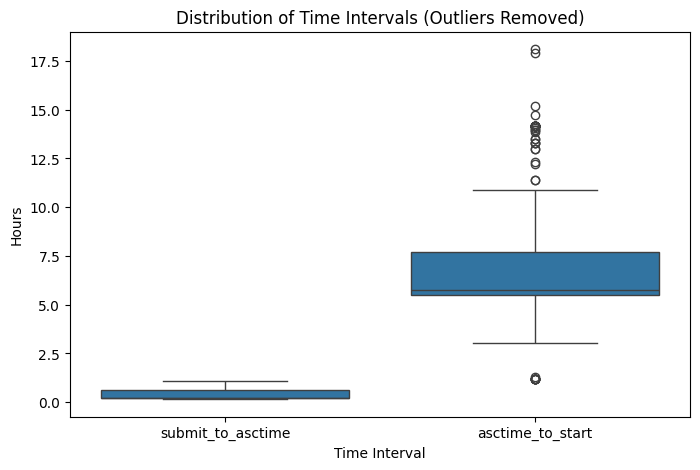

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant columns
df_plot = merged_df[['submit_to_asctime', 'asctime_to_start']]

# Function to remove outliers using IQR
def remove_outliers(df, columns):
    filtered_df = df.copy()
    for col in columns:
        Q1 = filtered_df[col].quantile(0.25)
        Q3 = filtered_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df

# Remove outliers
df_clean = remove_outliers(df_plot, ['submit_to_asctime', 'asctime_to_start'])

# Transform data for boxplot (convert from wide to long format)
df_melted = df_clean.melt(var_name="Time Interval", value_name="Hours")

# Create the boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="Time Interval", y="Hours", data=df_melted)

# Add title and labels
plt.title("Distribution of Time Intervals (Outliers Removed)")
plt.xlabel("Time Interval")
plt.ylabel("Hours")

# Show the plot
plt.show()

In [14]:
rules = pd.read_csv('rucio_rules_feb_2024.csv')

/tmp/ipykernel_120260/3105205117.py:1: DtypeWarning: Columns (11,14,23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  rules = pd.read_csv('rucio_rules_feb_2024.csv')


In [32]:
rules.head(1000)

,Unnamed: 0,ID,SUBSCRIPTION_ID,ACCOUNT,SCOPE,NAME,DID_TYPE,STATE,RSE_EXPRESSION,COPIES,...,STUCK_AT,PURGE_REPLICAS,IGNORE_AVAILABILITY,COMMENTS,IGNORE_ACCOUNT_LIMIT,CHILD_RULE_ID,PRIORITY,EOL_AT,SPLIT_CONTAINER,META
0,0,bytearray(b'D\xe3\xbe\xc5\xf1\xfdNQ\x9f;\xa3/\...,NaN,pilot,cond09_test,cond09_test.000048.gen.COND,D,O,BNL-OSG2_DATADISK,1.0,...,NaN,0.0,0.0,NaN,0.0,NaN,3.0,NaN,0.0,NaN
1,1,bytearray(b'U\x84\xb8\xc5=bH\x98\xb8\xa7hz\xd0...,NaN,pilot,cond09_test,cond09_test.000048.gen.COND,D,O,CERN-PROD_HOTDISK,1.0,...,NaN,0.0,0.0,NaN,0.0,NaN,3.0,NaN,0.0,NaN
2,2,bytearray(b'\xbf\xdd\xb8jep@;\xb2\xff[\xaf\xc7...,NaN,pilot,cond09_test,cond09_test.000048.gen.COND,D,O,CERN-PROD_DATATAPE,1.0,...,NaN,0.0,0.0,NaN,0.0,NaN,3.0,NaN,0.0,NaN
3,3,bytearray(b'\xca\xd8\xb4\\\x93SC\xf9\x85{\xf8\...,NaN,pilot,cond09_test,cond09_test.000049.gen.COND,D,O,CERN-PROD_DATATAPE,1.0,...,NaN,0.0,0.0,NaN,0.0,NaN,3.0,NaN,0.0,NaN
4,4,"bytearray(b'""vW_\x07\xf6DE\x99\xee\xa8\xb7\xc8...",NaN,pilot,cond09_test,cond09_test.000049.gen.COND,D,O,BNL-OSG2_DATADISK,1.0,...,NaN,0.0,0.0,NaN,0.0,NaN,3.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,bytearray(b'7\xcb\x18l\xe4\r@\xf1\xa7\x93\x01\...,bytearray(b'\x90?\xf2\xb2\xb8\x85KX\x95\x86\x8...,ddmadmin,data24_calib,data24_calib.00468290.calibration_LArElec-Ramp...,D,O,RAL-LCG2_DATATAPE,1.0,...,NaN,0.0,0.0,T0 RAW to T1 tape,0.0,NaN,3.0,2124-02-01 11:31:09,0.0,NaN
996,996,bytearray(b'\x9a\x7fm\xda\xe6\xf5O\x85\x95f\x8...,NaN,tzero,data24_calib,data24_calib.00468290.calibration_LArElec-Ramp...,D,O,CERN-PROD_RAW,1.0,...,NaN,0.0,1.0,NaN,0.0,NaN,3.0,2124-02-01 11:31:09,0.0,NaN
997,997,"bytearray(b""\'\x89\xcc\xaa\xd4\xd0D[\xb6\xf6\x...",bytearray(b'\x90?\xf2\xb2\xb8\x85KX\x95\x86\x8...,ddmadmin,data24_calib,data24_calib.00468291.calibration_LArElec-Ramp...,D,O,BNL-OSG2_DATATAPE,1.0,...,NaN,0.0,0.0,T0 RAW to T1 tape,0.0,NaN,3.0,2124-02-01 11:31:09,0.0,NaN
998,998,bytearray(b'\xba\x00\xfc\x99I\x03LW\xa3q\x07\x...,NaN,tzero,data24_calib,data24_calib.00468291.calibration_LArElec-Ramp...,D,O,CERN-PROD_RAW,1.0,...,NaN,0.0,1.0,NaN,0.0,NaN,3.0,2124-02-01 11:31:09,0.0,NaN


In [17]:
rules.columns

Index(['Unnamed: 0', 'ID', 'SUBSCRIPTION_ID', 'ACCOUNT', 'SCOPE', 'NAME',
       'DID_TYPE', 'STATE', 'RSE_EXPRESSION', 'COPIES', 'EXPIRES_AT', 'WEIGHT',
       'LOCKED', 'GROUPING', 'ERROR', 'UPDATED_AT', 'CREATED_AT',
       'LOCKS_OK_CNT', 'LOCKS_REPLICATING_CNT', 'LOCKS_STUCK_CNT',
       'SOURCE_REPLICA_EXPRESSION', 'ACTIVITY', 'NOTIFICATION', 'STUCK_AT',
       'PURGE_REPLICAS', 'IGNORE_AVAILABILITY', 'COMMENTS',
       'IGNORE_ACCOUNT_LIMIT', 'CHILD_RULE_ID', 'PRIORITY', 'EOL_AT',
       'SPLIT_CONTAINER', 'META'],
      dtype='object')

In [20]:
# Step 2: Merge the DataFrames on the dataset name
merged_df = feb_2024.merge(
    rules[['NAME', 'CREATED_AT', 'UPDATED_AT', 'EXPIRES_AT']], 
    left_on='dataset_name', 
    right_on='NAME', 
    how='left'
)

# Step 3: Rename the columns and add them to feb_24
merged_df['rucio_created_at'] = merged_df['CREATED_AT']
merged_df['rucio_updated_at'] = merged_df['UPDATED_AT']
merged_df['rucio_expires_at'] = merged_df['EXPIRES_AT']


In [21]:
merged_df = merged_df.drop(columns=['dataset_name', 'NAME', 'CREATED_AT', 'UPDATED_AT', 'EXPIRES_AT'])

In [22]:
print(merged_df[['dataset', 'rucio_created_at', 'rucio_updated_at', 'rucio_expires_at']])

                                                dataset rucio_created_at  \
0     mc16_13TeV:mc16_13TeV.700324.Sh_2211_Zmumu_max...              NaN   
1     mc16_13TeV:mc16_13TeV.700324.Sh_2211_Zmumu_max...              NaN   
2     mc16_13TeV:mc16_13TeV.700335.Sh_2211_Znunu_pTV...              NaN   
3     mc16_13TeV:mc16_13TeV.700335.Sh_2211_Znunu_pTV...              NaN   
4     mc16_13TeV:mc16_13TeV.364200.Sherpa_221_NN30NN...              NaN   
...                                                 ...              ...   
2564  data17_13TeV:data17_13TeV.00333487.physics_Mai...              NaN   
2565  data16_13TeV:data16_13TeV.00308047.physics_Mai...              NaN   
2566  data17_13TeV:data17_13TeV.00333469.physics_Mai...              NaN   
2567  data16_13TeV:data16_13TeV.00309375.physics_Mai...              NaN   
2568  data16_13TeV:data16_13TeV.00309640.physics_Mai...              NaN   

     rucio_updated_at rucio_expires_at  
0                 NaN              NaN  
1    

In [28]:
merged_df[merged_df['rucio_created_at'] != None]

,rule,resource,files,asctime,dataset,dataset_origin,year,energy,b_unit,datasetid,physics_process,production_step,data_format,ami_tags,root_taskID,rucio_created_at,rucio_updated_at,rucio_expires_at
0,type=DATADISK&datapolicynucleus=True&(cloud=US...,BNL-ATLAS_TAPE,9978,2024-02-01 06:39:04,mc16_13TeV:mc16_13TeV.700324.Sh_2211_Zmumu_max...,mc,16,13,TeV,700324,Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto,simul,HITS,e8351_e7400_s3126,29973945,NaN,NaN,NaN
1,type=DATADISK&datapolicynucleus=True&(cloud=US...,BNL-ATLAS_TAPE,49909,2024-02-01 06:39:04,mc16_13TeV:mc16_13TeV.700324.Sh_2211_Zmumu_max...,mc,16,13,TeV,700324,Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto,simul,HITS,e8351_e7400_s3126,29878398,NaN,NaN,NaN
2,type=DATADISK&datapolicynucleus=True&(cloud=US...,BNL-ATLAS_TAPE,9997,2024-02-01 06:39:04,mc16_13TeV:mc16_13TeV.700335.Sh_2211_Znunu_pTV...,mc,16,13,TeV,700335,Sh_2211_Znunu_pTV2_BFilter,merge,HITS,e8351_e7400_s3126_s3136,30877630,NaN,NaN,NaN
3,type=DATADISK&datapolicynucleus=True&(cloud=US...,BNL-ATLAS_TAPE,45930,2024-02-01 06:39:04,mc16_13TeV:mc16_13TeV.700335.Sh_2211_Znunu_pTV...,mc,16,13,TeV,700335,Sh_2211_Znunu_pTV2_BFilter,simul,HITS,e8351_e7400_s3126,30523833,NaN,NaN,NaN
4,type=DATADISK&datapolicynucleus=True\(cloud=US...,FZK-LCG2_TAPE,240,2024-02-01 07:39:05,mc16_13TeV:mc16_13TeV.364200.Sherpa_221_NN30NN...,mc,16,13,TeV,364200,Sherpa_221_NN30NNLO_Zmm_Mll10_40_MAXHTPTV70_28...,merge,AOD,e5421_e5984_s3126_r10724_r10726,14874395,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,type=DATADISK&datapolicynucleus=True\(cloud=US...,RAL-LCG2_TAPE,6454,2024-02-29 06:18:36,data17_13TeV:data17_13TeV.00333487.physics_Mai...,data,17,13,TeV,00333487,physics_Main,recon,DRAW_RPVLL,r11782,20624343,NaN,NaN,NaN
2565,type=DATADISK&datapolicynucleus=True\(cloud=US...,RAL-LCG2_TAPE,11653,2024-02-29 06:18:38,data16_13TeV:data16_13TeV.00308047.physics_Mai...,data,16,13,TeV,00308047,physics_Main,recon,DRAW_RPVLL,r11782,20777294,NaN,NaN,NaN
2566,type=DATADISK&datapolicynucleus=True&(cloud=US...,TRIUMF-LCG2_TAPE,2329,2024-02-29 06:18:42,data17_13TeV:data17_13TeV.00333469.physics_Mai...,data,17,13,TeV,00333469,physics_Main,recon,DRAW_RPVLL,r11782,20624339,NaN,NaN,NaN
2567,type=DATADISK&datapolicynucleus=True&(cloud=US...,TRIUMF-LCG2_TAPE,3091,2024-02-29 06:18:42,data16_13TeV:data16_13TeV.00309375.physics_Mai...,data,16,13,TeV,00309375,physics_Main,recon,DRAW_RPVLL,r11782,20777303,NaN,NaN,NaN


In [30]:
# Step 1: Ensure 'created_at' and 'rucio_created_at' are in datetime format
merged_df['asctime'] = pd.to_datetime(merged_df['asctime'])
merged_df['rucio_created_at'] = pd.to_datetime(merged_df['rucio_created_at'])

# Step 2: Calculate the time difference and convert to milliseconds
merged_df['time_diff_ms'] = (merged_df['rucio_created_at'] - merged_df['asctime']).dt.total_seconds() * 1000

# Step 3: Check the resulting DataFrame
print(merged_df[['dataset', 'rucio_created_at', 'asctime', 'time_diff_ms']])

                                                dataset rucio_created_at  \
0     mc16_13TeV:mc16_13TeV.700324.Sh_2211_Zmumu_max...              NaT   
1     mc16_13TeV:mc16_13TeV.700324.Sh_2211_Zmumu_max...              NaT   
2     mc16_13TeV:mc16_13TeV.700335.Sh_2211_Znunu_pTV...              NaT   
3     mc16_13TeV:mc16_13TeV.700335.Sh_2211_Znunu_pTV...              NaT   
4     mc16_13TeV:mc16_13TeV.364200.Sherpa_221_NN30NN...              NaT   
...                                                 ...              ...   
2564  data17_13TeV:data17_13TeV.00333487.physics_Mai...              NaT   
2565  data16_13TeV:data16_13TeV.00308047.physics_Mai...              NaT   
2566  data17_13TeV:data17_13TeV.00333469.physics_Mai...              NaT   
2567  data16_13TeV:data16_13TeV.00309375.physics_Mai...              NaT   
2568  data16_13TeV:data16_13TeV.00309640.physics_Mai...              NaT   

                 asctime  time_diff_ms  
0    2024-02-01 06:39:04           NaN  
1    

In [31]:
merged_df[merged_df['time_diff_ms'] != None]

,rule,resource,files,asctime,dataset,dataset_origin,year,energy,b_unit,datasetid,physics_process,production_step,data_format,ami_tags,root_taskID,rucio_created_at,rucio_updated_at,rucio_expires_at,time_diff_ms
0,type=DATADISK&datapolicynucleus=True&(cloud=US...,BNL-ATLAS_TAPE,9978,2024-02-01 06:39:04,mc16_13TeV:mc16_13TeV.700324.Sh_2211_Zmumu_max...,mc,16,13,TeV,700324,Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto,simul,HITS,e8351_e7400_s3126,29973945,NaT,NaN,NaN,NaN
1,type=DATADISK&datapolicynucleus=True&(cloud=US...,BNL-ATLAS_TAPE,49909,2024-02-01 06:39:04,mc16_13TeV:mc16_13TeV.700324.Sh_2211_Zmumu_max...,mc,16,13,TeV,700324,Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto,simul,HITS,e8351_e7400_s3126,29878398,NaT,NaN,NaN,NaN
2,type=DATADISK&datapolicynucleus=True&(cloud=US...,BNL-ATLAS_TAPE,9997,2024-02-01 06:39:04,mc16_13TeV:mc16_13TeV.700335.Sh_2211_Znunu_pTV...,mc,16,13,TeV,700335,Sh_2211_Znunu_pTV2_BFilter,merge,HITS,e8351_e7400_s3126_s3136,30877630,NaT,NaN,NaN,NaN
3,type=DATADISK&datapolicynucleus=True&(cloud=US...,BNL-ATLAS_TAPE,45930,2024-02-01 06:39:04,mc16_13TeV:mc16_13TeV.700335.Sh_2211_Znunu_pTV...,mc,16,13,TeV,700335,Sh_2211_Znunu_pTV2_BFilter,simul,HITS,e8351_e7400_s3126,30523833,NaT,NaN,NaN,NaN
4,type=DATADISK&datapolicynucleus=True\(cloud=US...,FZK-LCG2_TAPE,240,2024-02-01 07:39:05,mc16_13TeV:mc16_13TeV.364200.Sherpa_221_NN30NN...,mc,16,13,TeV,364200,Sherpa_221_NN30NNLO_Zmm_Mll10_40_MAXHTPTV70_28...,merge,AOD,e5421_e5984_s3126_r10724_r10726,14874395,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,type=DATADISK&datapolicynucleus=True\(cloud=US...,RAL-LCG2_TAPE,6454,2024-02-29 06:18:36,data17_13TeV:data17_13TeV.00333487.physics_Mai...,data,17,13,TeV,00333487,physics_Main,recon,DRAW_RPVLL,r11782,20624343,NaT,NaN,NaN,NaN
2565,type=DATADISK&datapolicynucleus=True\(cloud=US...,RAL-LCG2_TAPE,11653,2024-02-29 06:18:38,data16_13TeV:data16_13TeV.00308047.physics_Mai...,data,16,13,TeV,00308047,physics_Main,recon,DRAW_RPVLL,r11782,20777294,NaT,NaN,NaN,NaN
2566,type=DATADISK&datapolicynucleus=True&(cloud=US...,TRIUMF-LCG2_TAPE,2329,2024-02-29 06:18:42,data17_13TeV:data17_13TeV.00333469.physics_Mai...,data,17,13,TeV,00333469,physics_Main,recon,DRAW_RPVLL,r11782,20624339,NaT,NaN,NaN,NaN
2567,type=DATADISK&datapolicynucleus=True&(cloud=US...,TRIUMF-LCG2_TAPE,3091,2024-02-29 06:18:42,data16_13TeV:data16_13TeV.00309375.physics_Mai...,data,16,13,TeV,00309375,physics_Main,recon,DRAW_RPVLL,r11782,20777303,NaT,NaN,NaN,NaN


In [ ]:
import matplotlib.pyplot as plt

# Plot daily record counts
plt.figure(figsize=(12, 6))
plt.plot(daily_counts_pd['day'], daily_counts_pd['record_count'], marker='o', linestyle='-')
plt.title('Number of Records per Day [2025/02/13]')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.grid(True)
plt.tight_layout()
plt.show()